In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn import metrics
import itertools
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import csgraph
import umap
from sklearn import linear_model
from collections import Counter
import sklearn
import scipy.stats as sps
from scipy.spatial.distance import cdist
from importlib import reload
import mygene
import sys
import gget

# locals
sys.path.append("../")
import utils as ut
reload(ut)

2023-06-12 09:09:11.418403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 09:09:16.878418: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-12 09:09:18.768230: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-12 09:09:18.768250: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/continuum/../utils.py'>

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
    'Monocytes',
]

print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = lf.drop_duplicates(subset='cellId')
    lf = lf[lf['cellType'].isin(macTypes)]
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    

    cellIds = lf['cellId'].to_list()
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']

    rf = rf[rf.index.isin(cellIds)]
    print(f"{key=} {lf.shape=} {rf.shape}")
    
    rf = ut.normalize(rf, 1e6)
    rna[key] = rf
    

print('done')


ND...
key='ND' lf.shape=(536, 6) (534, 31053)
HFD8...
key='HFD8' lf.shape=(2909, 6) (2902, 31053)
HFD14...
key='HFD14' lf.shape=(4903, 6) (4893, 31053)
done


In [3]:
def getGroup(rna, labels, key, ctype):
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'] == ctype]['cellId'].to_list()
    return rf[rf.index.isin(cellIds)]

In [4]:
# break

In [5]:
pathways = {    
    "00561" :  "Glycerolipid metabolism",
    "00600" :  "Sphingolipid metabolism",
    "00190" :  "Oxidative phosphorylation",
    "04975" :  "Fat digestion and absorption",
    "04979" :  "Cholesterol metabolism",
    "03320" :  "PPAR signaling pathway",
    # "04512" :  "ECM-receptor interaction",
    # "04514" :  "Cell adhesion molecules",
    "04142" :  "Lysosome",
    "04140" :  "Autophagy",
    "04210" :  "Apoptosis",
    "04216" :  "Ferroptosis",
    "04217" :  "Necroptosis",
}

pdf = []

for pid, pname in pathways.items():
    pidFull = f"mmu{pid}"
    g = ut.parseKEGG(pidFull)
    g = [x.upper() for x in g]
    g = [x for x in g if x in rna['ND'].columns.to_list()]

    tmp = pd.DataFrame(g, columns=['gene'])
    tmp['pathway'] = pname

    pdf.append(tmp)

pdf = pd.concat(pdf)
print(f"{pdf.shape=}")
print()
print(pdf['pathway'].value_counts())
print()
pdf.head()

pdf.shape=(1006, 2)

pathway
Necroptosis                     145
Autophagy                       139
Lysosome                        135
Apoptosis                       135
Oxidative phosphorylation       119
PPAR signaling pathway           87
Glycerolipid metabolism          63
Sphingolipid metabolism          53
Cholesterol metabolism           49
Fat digestion and absorption     42
Ferroptosis                      39
Name: count, dtype: int64



,gene,pathway
0,GLYCTK,Glycerolipid metabolism
1,ALDH2,Glycerolipid metabolism
2,ALDH3A2,Glycerolipid metabolism
3,ALDH1B1,Glycerolipid metabolism
4,ALDH7A1,Glycerolipid metabolism


In [7]:
res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')

    # get all unique pathway genes    
    allpwayGenes = pdf['gene'].unique()


    for mtype in macTypes:
        cellIds = lf[lf['cellType'] == mtype]['cellId'].to_list()
        rx = rf[rf.index.isin(cellIds)][allpwayGenes]
        gdf = pd.DataFrame(rx.mean(axis=0))
        gdf = gdf.reset_index(drop=False)
        gdf.columns = ['gene', 'meanExp']
        gdf['key'] = key
        gdf['cellType'] = mtype
        res.append(gdf)

res = pd.concat(res)
print(f"{res.shape=}")
res.head()

res.shape=(12600, 4)


,gene,meanExp,key,cellType
0,GLYCTK,0.0,ND,Mac1
1,ALDH2,291.723908,ND,Mac1
2,ALDH3A2,25.275032,ND,Mac1
3,ALDH1B1,1.733367,ND,Mac1
4,ALDH7A1,74.680387,ND,Mac1


In [98]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 10

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

for pname in pdf['pathway'].unique():    
    pGenes = pdf[pdf['pathway'] == pname]['gene'].unique()
    pdx = res[res['gene'].isin(pGenes)]

    # filter out genes whose maximum expression is zero 
    g = pdx.groupby('gene')['meanExp'].max()
    g = g[g > 1].index
    pdx = pdx[pdx['gene'].isin(g)]


    pdx = pd.pivot_table(pdx, index=['gene', 'key'], columns='cellType', values='meanExp')

    print(pname)
    print(pdx.head())
    
    break
    

   

Glycerolipid metabolism
cellType            Mac1       Mac2       Mac3       Mac4       Mac5
gene    key                                                         
ABHD16A HFD14  49.348624   8.437964  44.116678  38.275794   39.98856
        HFD8   42.711433  41.686544  32.325631  34.848518  45.284057
        ND     43.873733  66.743864  26.093833  30.000508  14.863403
AGK     HFD14   8.559417   1.698947   11.11186  13.722081   12.74087
        HFD8   11.681711  14.637097   8.427399  10.947587  14.994188


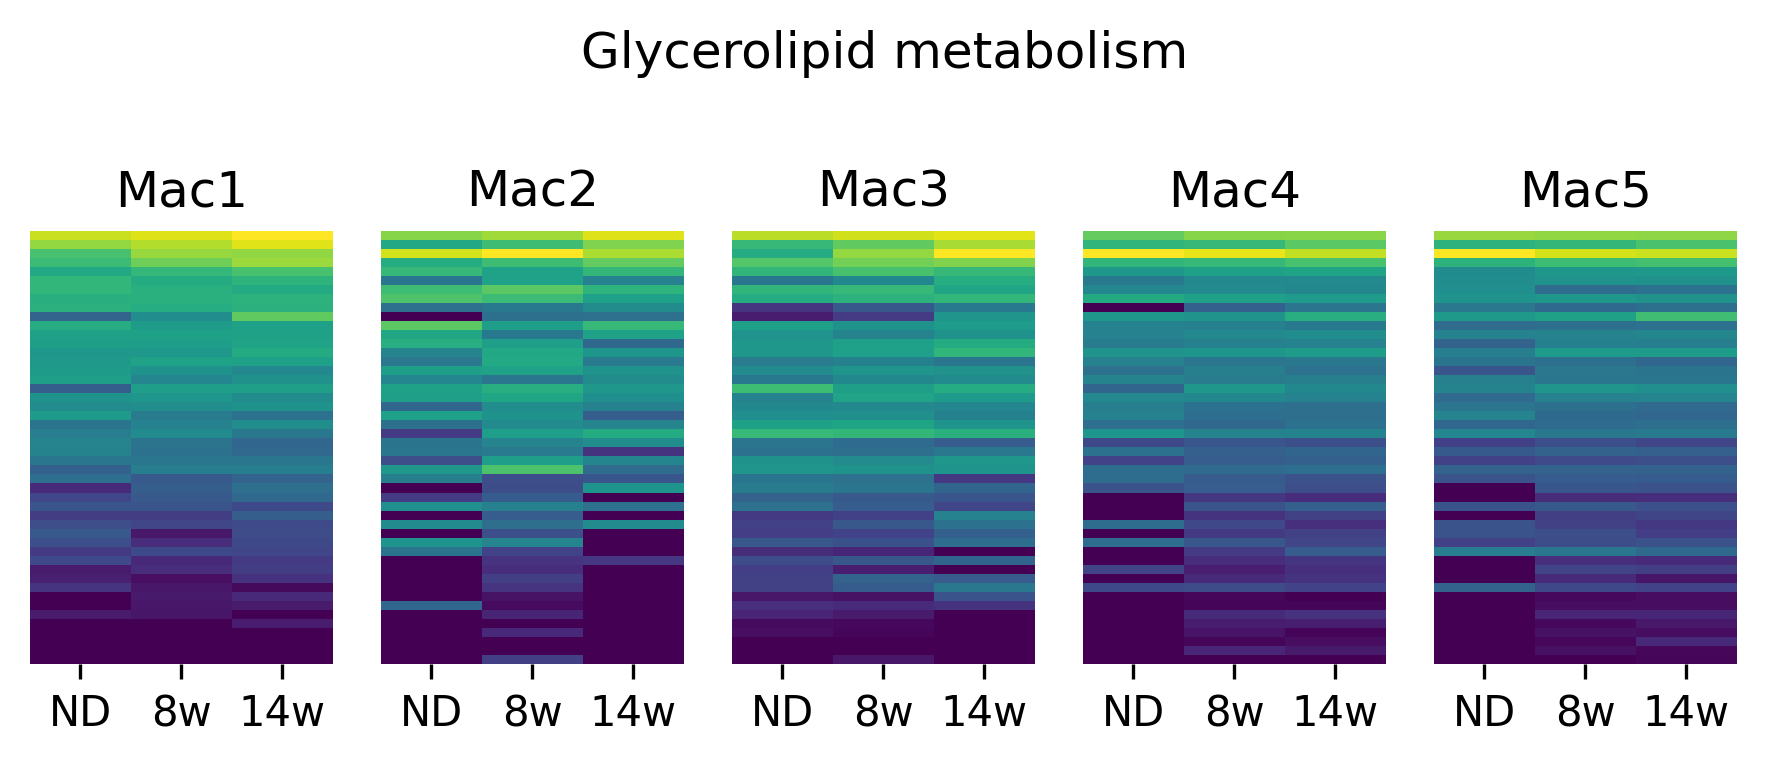

In [124]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2.5

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

for pname in pdf['pathway'].unique():    
    pGenes = pdf[pdf['pathway'] == pname]['gene'].unique()
    pdx = res[res['gene'].isin(pGenes)]

    # filter out genes whose maximum expression is zero 
    g = pdx.groupby('gene')['meanExp'].max()
    g = g[g > 1].index
    pdx = pdx[pdx['gene'].isin(g)]

    pdx['keyName'] = pdx['key'].map(keyMap)
    

    fig, axs = plt.subplots(1, 5, sharey=True)
    axs = axs.ravel()

    for i,ct in enumerate(macTypes):
        tdf = pdx[pdx['cellType'] == ct]
        tdf = pd.pivot_table(tdf, 
                             index='keyName', 
                             columns='gene', 
                             values='meanExp')
        if i == 0:
            sortOrder = tdf.mean(axis=0).sort_values(ascending=False).index
        
        tdf = tdf[sortOrder]
        tdf.columns = [x.lower().capitalize() for x in tdf.columns]
        
        tdf = np.log2(tdf.astype(float) + 1).T
        tdf = tdf.fillna(0)

        # # drop early macrophage columns
        # if i > 2:
        #     tdf[['ND']] = np.nan

        sns.heatmap(data=tdf,
                    cmap='viridis',
                    cbar=False,
                    ax=axs[i])
                    # annot=True,
                    # fmt=".1f",
                    # annot_kws={"fontsize":3})

        axs[i].set_xlabel("")
        axs[i].set_yticks([])
        axs[i].set_title(ct)
        # axs[i].tick_params(axis='both', which='major', labelsize=8)
        axs[i].invert_xaxis()
        
    plt.suptitle(pname, y=1)
    plt.tight_layout()
    plt.show()

    break

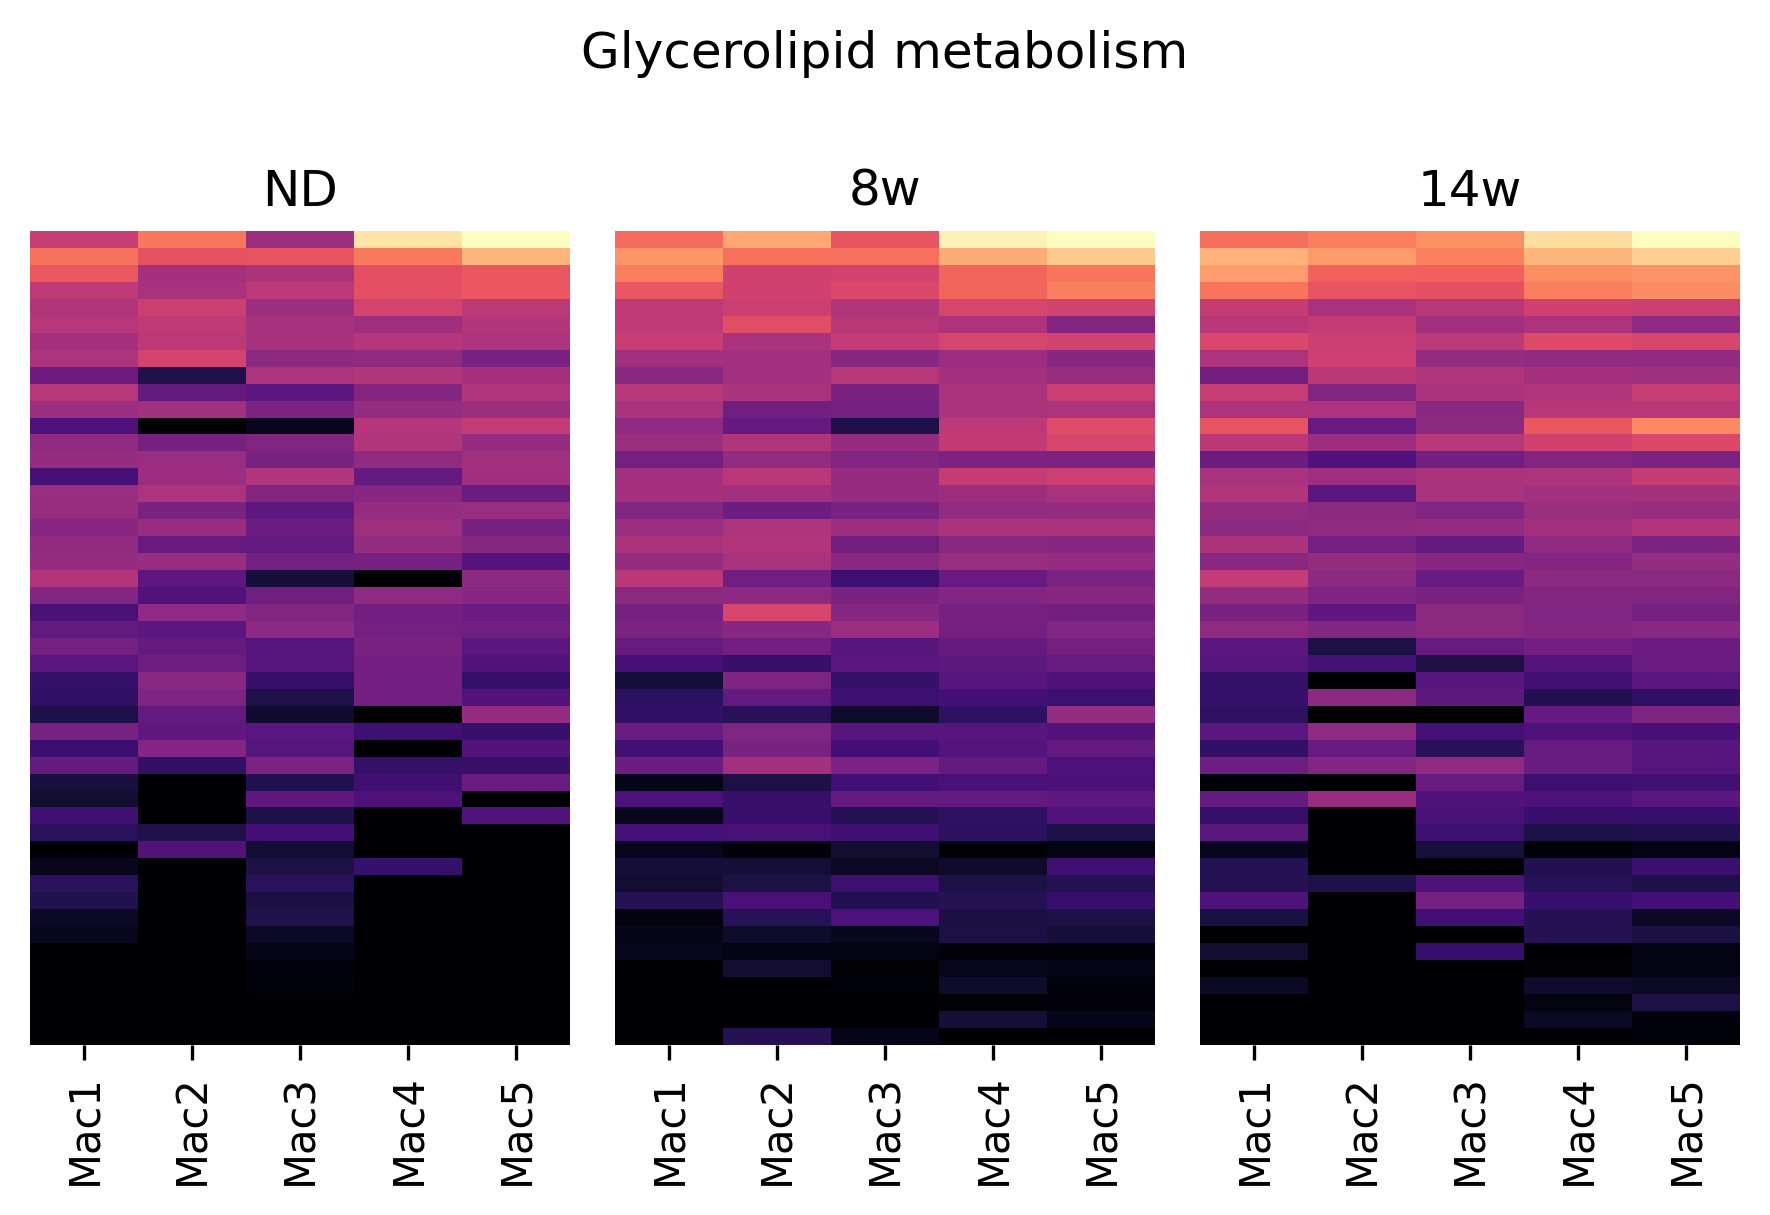

In [125]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

for pname in pdf['pathway'].unique():    
    pGenes = pdf[pdf['pathway'] == pname]['gene'].unique()
    pdx = res[res['gene'].isin(pGenes)]

    # filter out genes whose maximum expression is zero 
    g = pdx.groupby('gene')['meanExp'].max()
    g = g[g > 1].index
    pdx = pdx[pdx['gene'].isin(g)]
    

    fig, axs = plt.subplots(1, 3, sharey=True)
    axs = axs.ravel()

    for i,key in enumerate(keys):
        tdf = pdx[pdx['key'] == key]
            

        tdf = pd.pivot_table(tdf, index='cellType', columns='gene', values='meanExp')

        
        if i == 0:
            sortOrder = tdf.mean(axis=0).sort_values(ascending=False).index
        
        tdf = tdf[sortOrder]
        tdf.columns = [x.lower().capitalize() for x in tdf.columns]
        
        tdf = np.log2(tdf.astype(float) + 1).T
        tdf = tdf.fillna(0)

        # if i == 0:
        #     tdf = tdf.drop(columns=['Mac4', 'Mac5'])
        #     # tdf[['Mac4', 'Mac5']] = np.nan

        sns.heatmap(data=tdf,
                    cmap='magma',
                    cbar=False,
                    ax=axs[i])
    
                    # annot=True,
                    # fmt=".1f",
                    # annot_kws={"fontsize":3})

        axs[i].set_xlabel("")
        axs[i].set_xlabel("")
        axs[i].set_yticks([])
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].set_title(keyMap[key])
        #axs[i].tick_params(axis='y', which='major', labelsize=8)
        
    plt.suptitle(pname, y=1)
    plt.tight_layout()
    plt.show()
    break

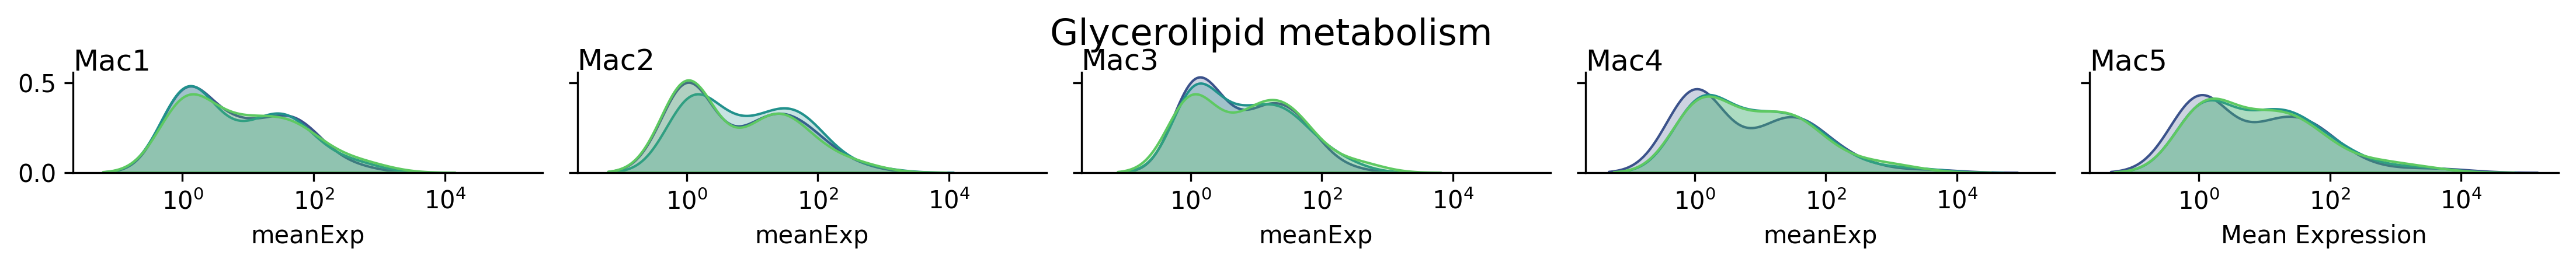

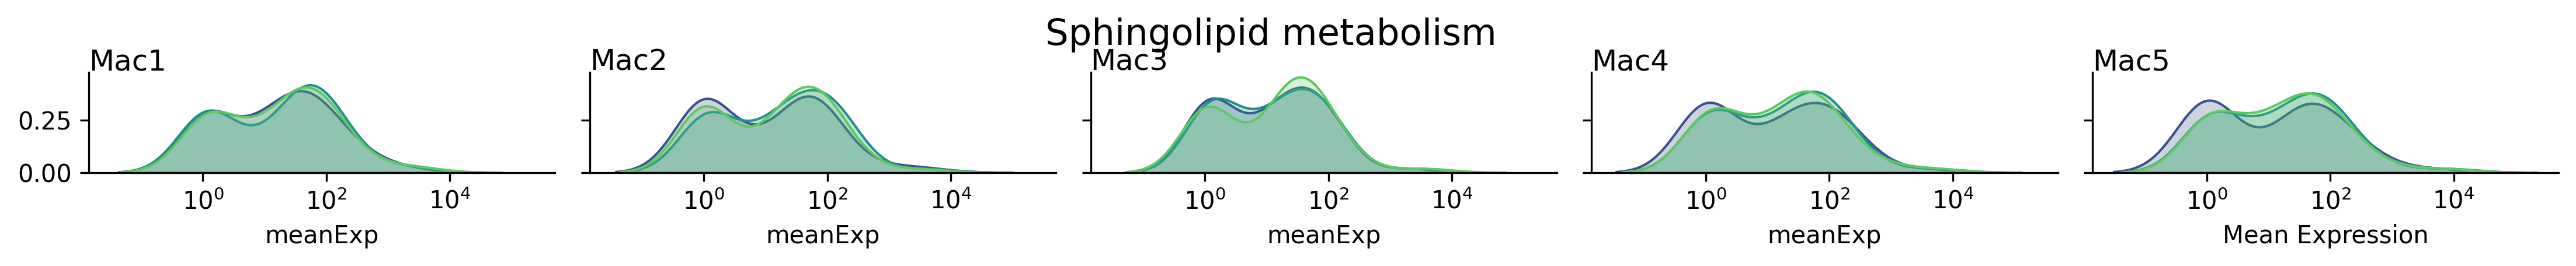

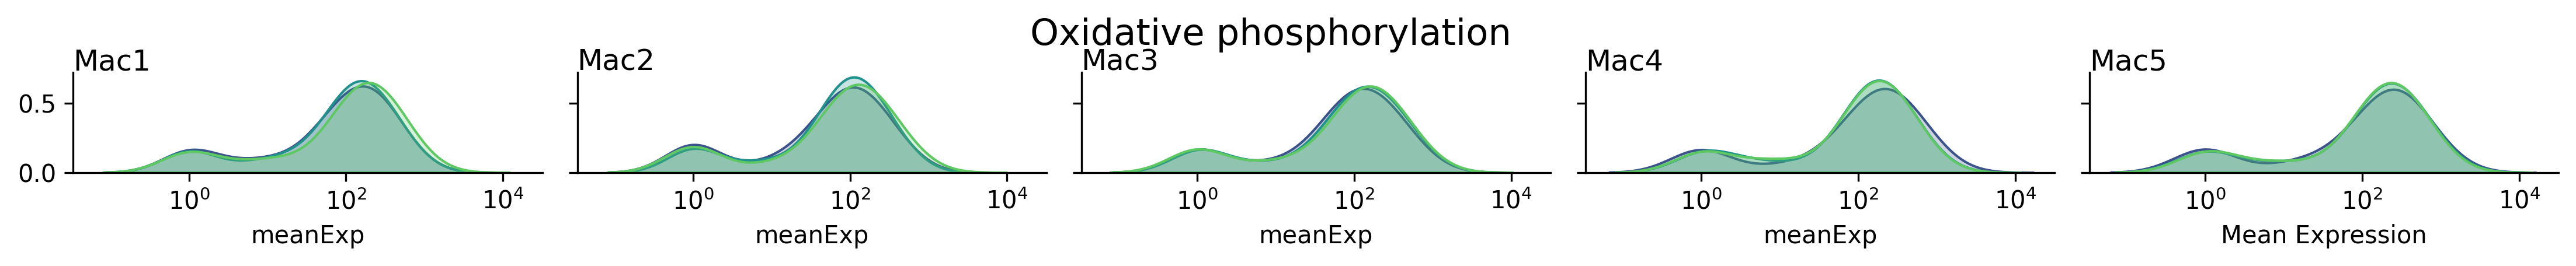

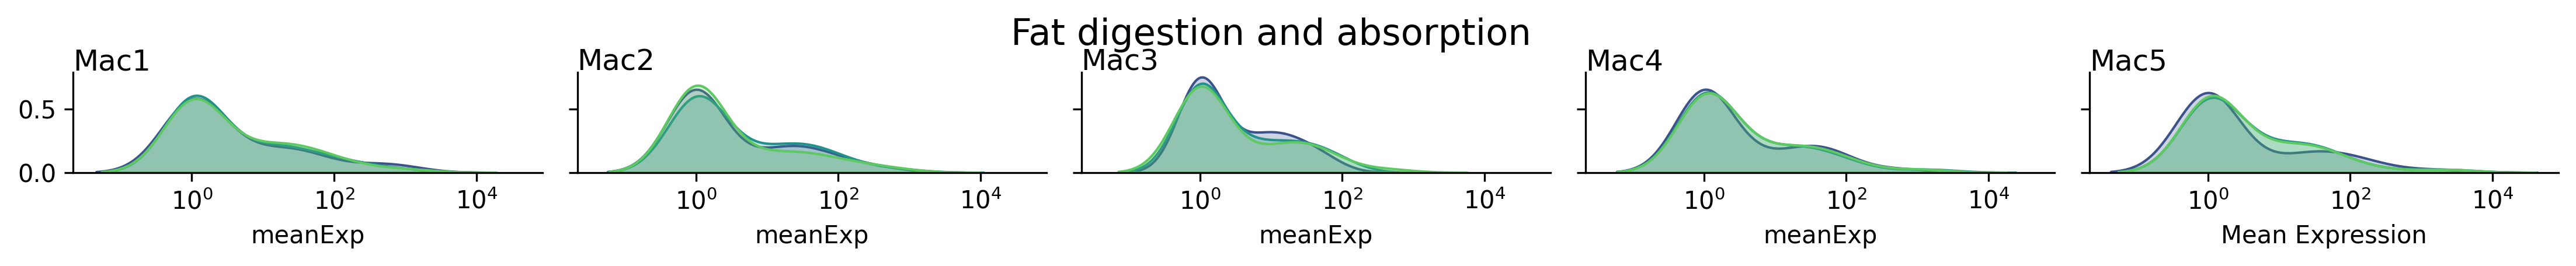

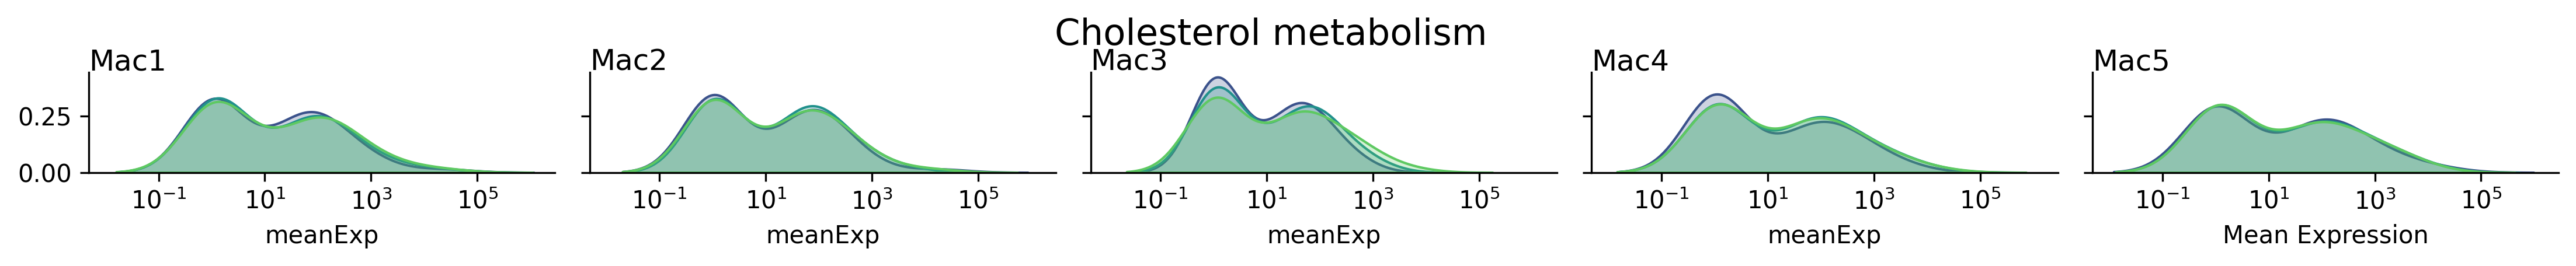

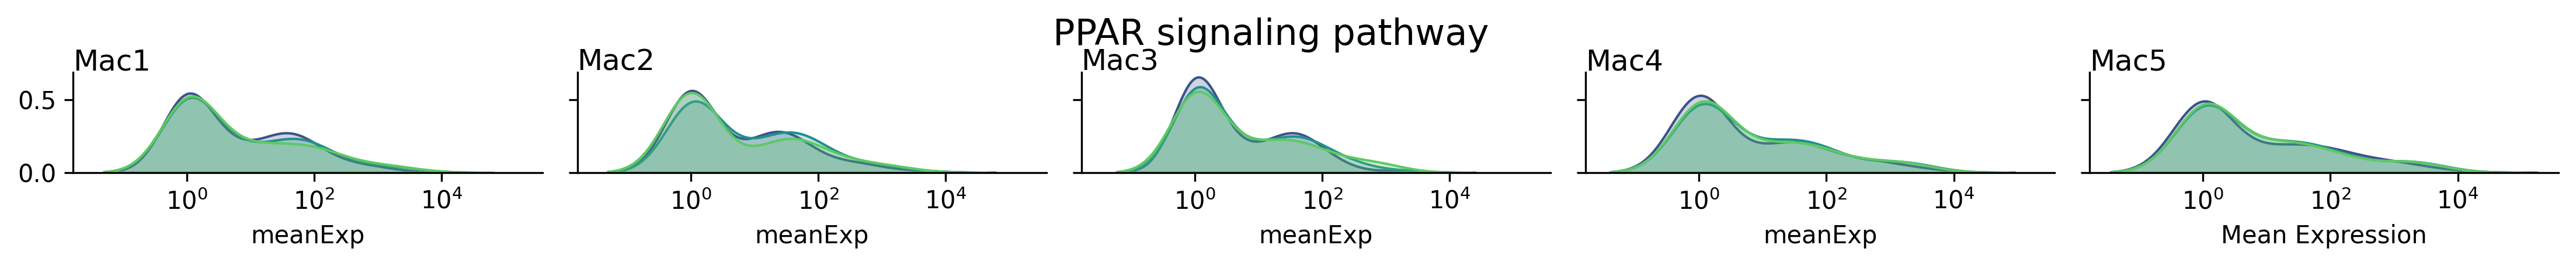

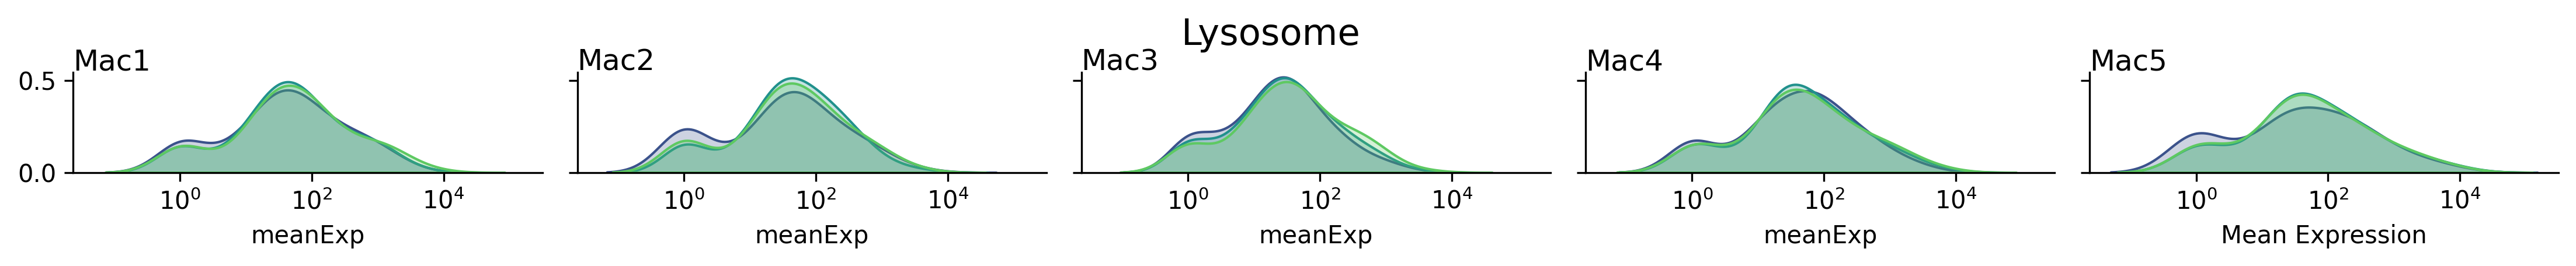

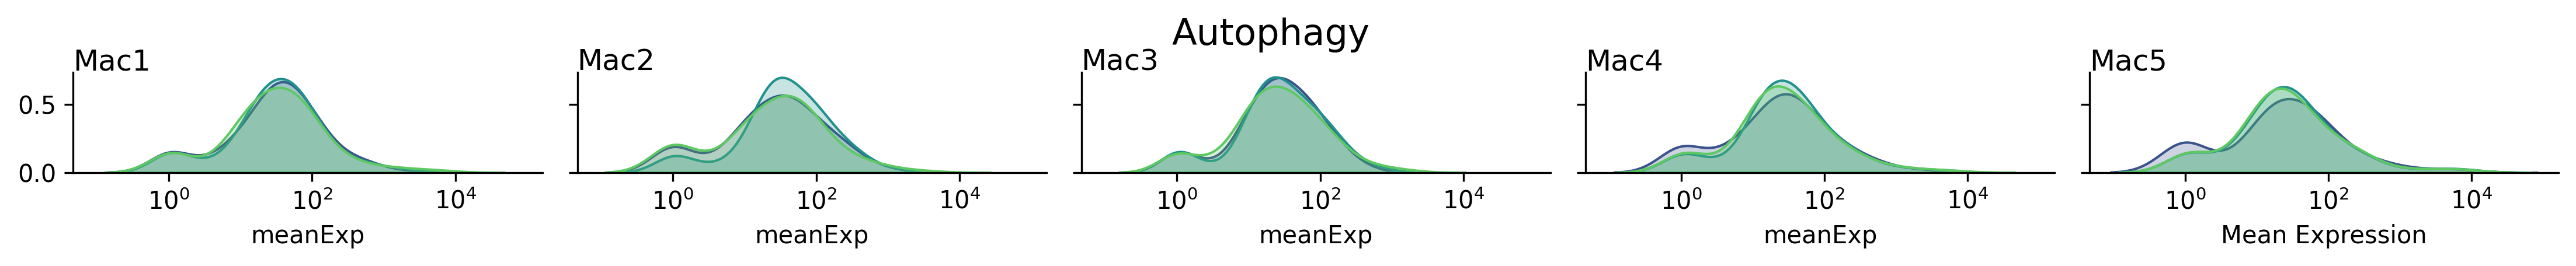

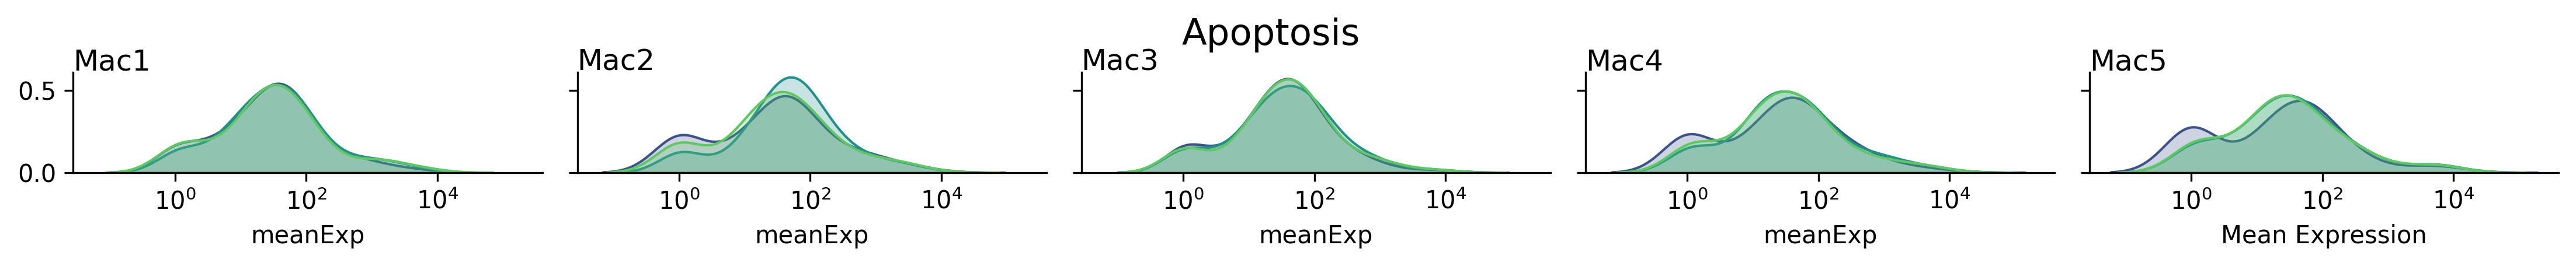

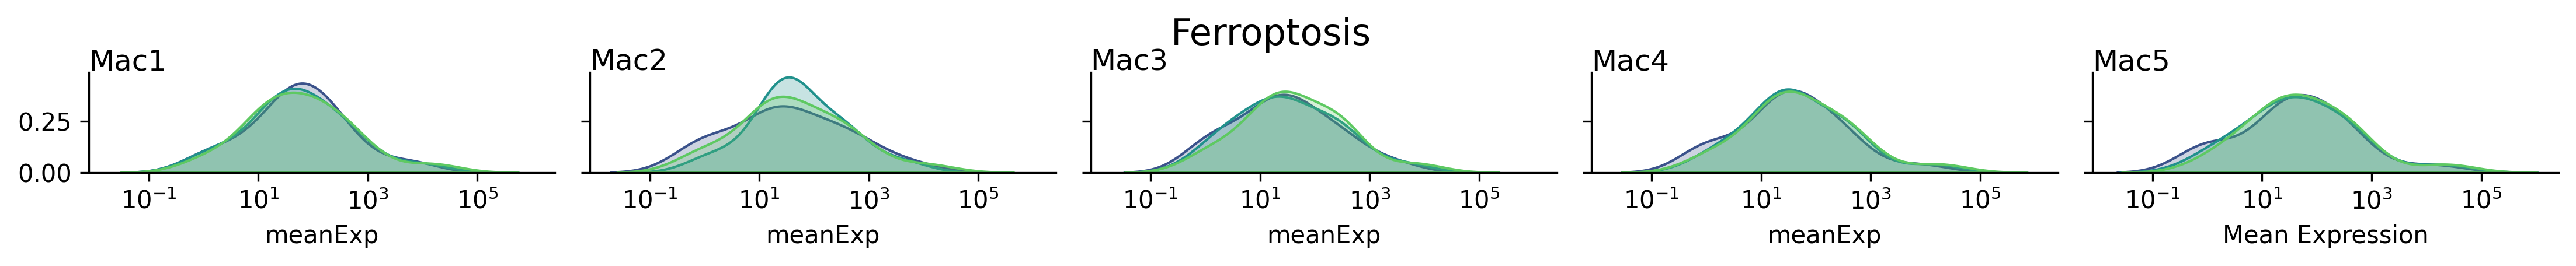

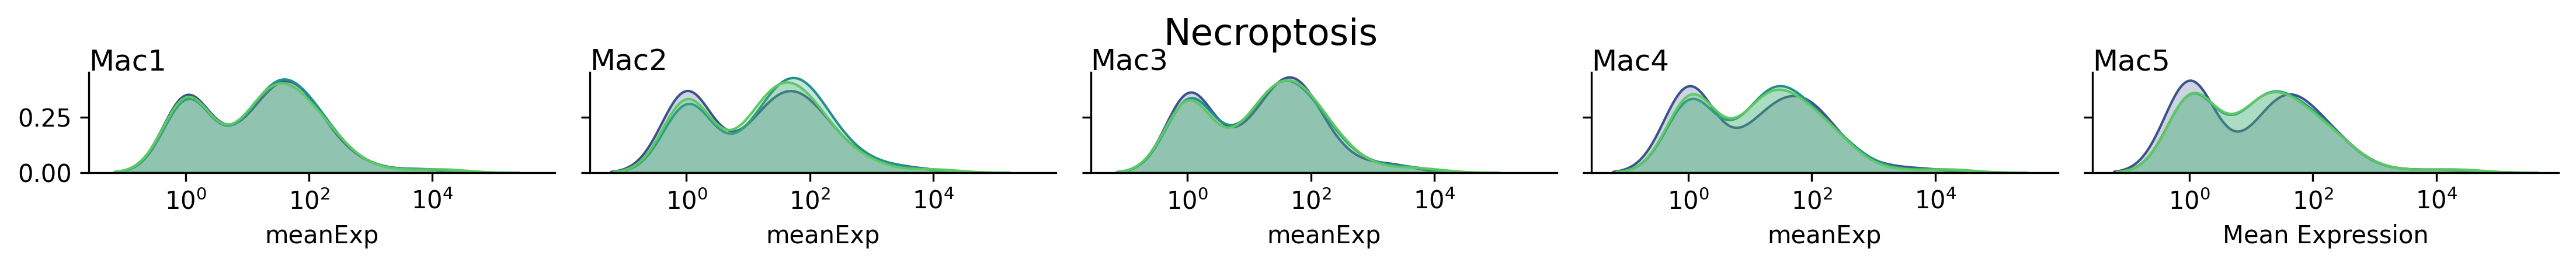

In [241]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

for pname in pdf['pathway'].unique():    
    pGenes = pdf[pdf['pathway'] == pname]['gene'].unique()
    pdx = res[res['gene'].isin(pGenes)].reset_index()
    # pdx = pdx[pdx['meanExp'] > 0]
    # pdx['meanExp'] = pdx['meanExp'].fillna(0)
    pdx['meanExp'] = pdx['meanExp'] + 1.0
    

    g = sns.FacetGrid(pdx, 
                      # row="cellType", 
                      col='cellType',
                      hue="key", 
                      # sharex=False,
                      height=1.5, 
                      aspect=2,
                      palette='viridis')

        # Draw the densities in a few steps
    g.map(sns.kdeplot, "meanExp",
          bw_adjust=1.1, 
          clip_on=True,
          common_norm=False,
          fill=True, 
          log_scale=True,
          linewidth=1.)


    g.despine()
    g.set_titles("")
    g.set(ylabel="")

    for ax, label in zip(g.axes.flat, pdx['cellType'].unique()):
        ax.text(0, 1.1, label, 
                fontsize=12,
                ha="left", 
                va="center", 
                transform=ax.transAxes)
        
        ax.set_facecolor('None')

    plt.suptitle(pname, fontsize=15)
    plt.xlabel('Mean Expression')
    # plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
    # plt.xlabel('Mean Expression')
    
    # sns.move_legend(plt.gca(), 
    #                 title="",
    #                 frameon=False,
    #                 loc='upper right', 
    #                 bbox_to_anchor=(1.4, 1.02))

    plt.show()
    # break



# DEG

In [137]:
deg = []

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')

    # get all unique pathway genes    
    allpwayGenes = pdf['gene'].unique()


    for mtype in macTypes:
        cellIds = lf[lf['cellType'] == mtype]['cellId'].to_list()
        mask = rf.index.isin(cellIds)

        inGroup = rf[mask]
        outGroup = rf[~mask]

        for g in allpwayGenes:
            score, pval = scipy.stats.ranksums(inGroup[g], 
                                   outGroup[g],
                                   alternative='two-sided')

            lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)

            row = {
                'gene' : g,
                'key' : key,
                'cellType' : mtype,
                'score' : score,
                'pval' : pval,
                'log2foldchange' : lfc,
            }

            deg.append(row)
        
deg = pd.DataFrame(deg)
print(f"{deg.shape=}")
deg.head()

deg.shape=(12600, 6)


,gene,key,cellType,score,pval,log2foldchange
0,GLYCTK,ND,Mac1,-0.262641,7.928271e-01,-1.066341
1,ALDH2,ND,Mac1,6.907851,4.920517e-12,1.502536
2,ALDH3A2,ND,Mac1,0.287747,7.735407e-01,0.312530
3,ALDH1B1,ND,Mac1,-0.697480,4.855026e-01,-0.639778
4,ALDH7A1,ND,Mac1,4.479385,7.485847e-06,4.180407


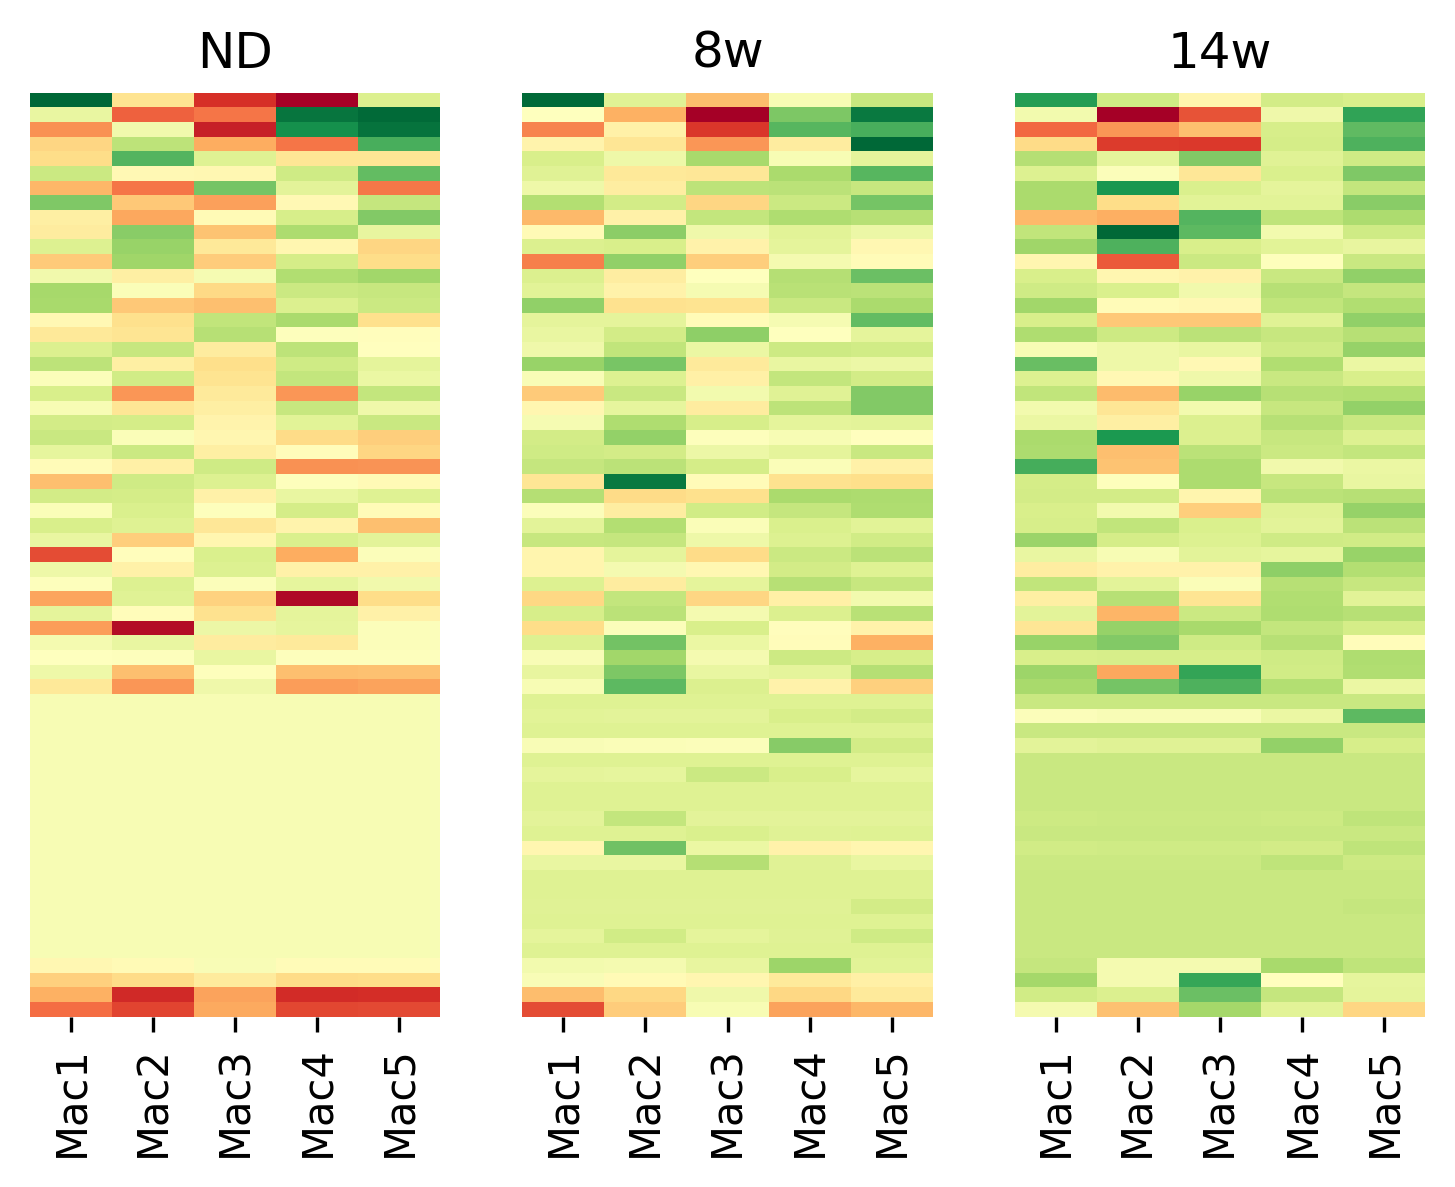

In [164]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

for pname in pdf['pathway'].unique():    
    pGenes = pdf[pdf['pathway'] == pname]['gene'].unique()
    pdx = deg[deg['gene'].isin(pGenes)]

  
    fig, axs = plt.subplots(1, 3, sharey=True)
    axs = axs.ravel()

    for i,key in enumerate(keys):
        
        tdf = pdx[pdx['key'] == key]
    
        
        tdf = pd.pivot_table(tdf,
                             index='cellType',
                             columns='gene', 
                             values='log2foldchange')

        if i == 0:
            sortOrder = tdf.max(axis=0).sort_values(ascending=False).index
            
        tdf = tdf[sortOrder]
        tdf = tdf.T
        sns.heatmap(data=tdf,
                    ax=axs[i],
                    cbar=False,
                    cmap='RdYlGn')

        axs[i].set_xlabel("")
        axs[i].set_ylabel("")
        axs[i].set_yticks([])
        axs[i].tick_params(axis='x', rotation=90)
        axs[i].set_title(keyMap[key])
        # break
    break

In [157]:
sortOrder

Index(['LPL', 'AKR1A1', 'ALDH2', 'AKR1B3', 'DGKZ', 'DGKD', 'ALDH9A1', 'LPIN2',
       'AGPAT4', 'AGPAT3', 'AKR1B10', 'AKR1B8', 'PNPLA2', 'AGPAT1', 'GLA',
       'ABHD16A', 'AGPAT2', 'AGPAT5', 'LPIN1', 'GPAT4', 'ALDH7A1', 'ALDH3A2',
       'DGAT1', 'PLPP2', 'AGK', 'PLPP5', 'GK', 'DGKE', 'MGLL', 'DGKQ', 'DGKH',
       'DGKA', 'ALDH1B1', 'LCLAT1', 'TKFC', 'MBOAT1', 'GLYCTK', 'PLPP3',
       'DGAT2', 'PLPP1', 'DGKG', 'MOGAT1', 'GPAT3', 'GPAM', 'LIPC', 'PLPP4',
       'AKR1B7', 'DGKI'],
      dtype='object', name='gene')

In [ ]:
break

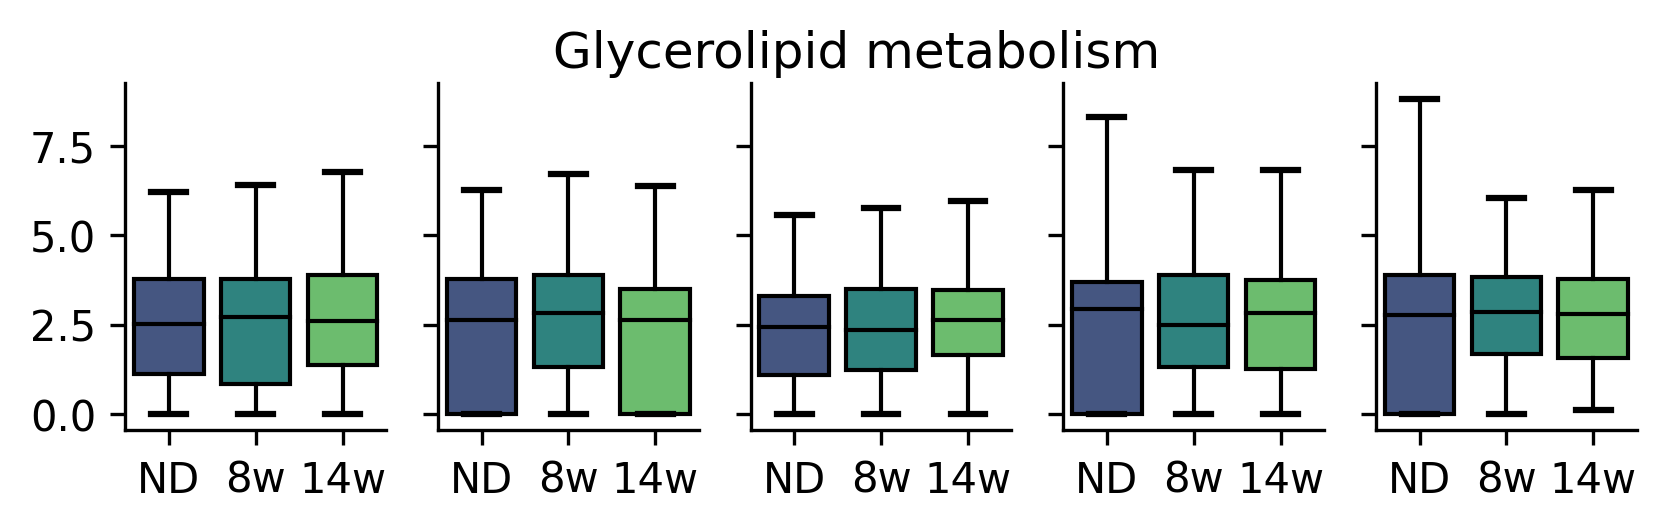

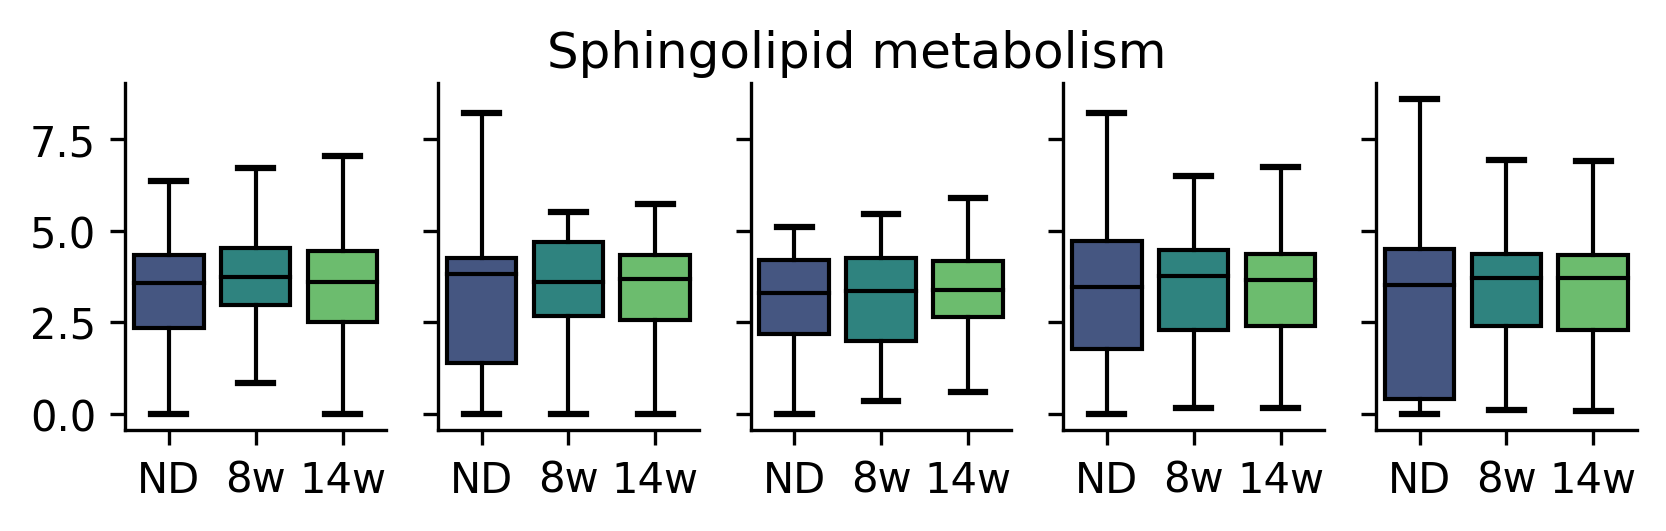

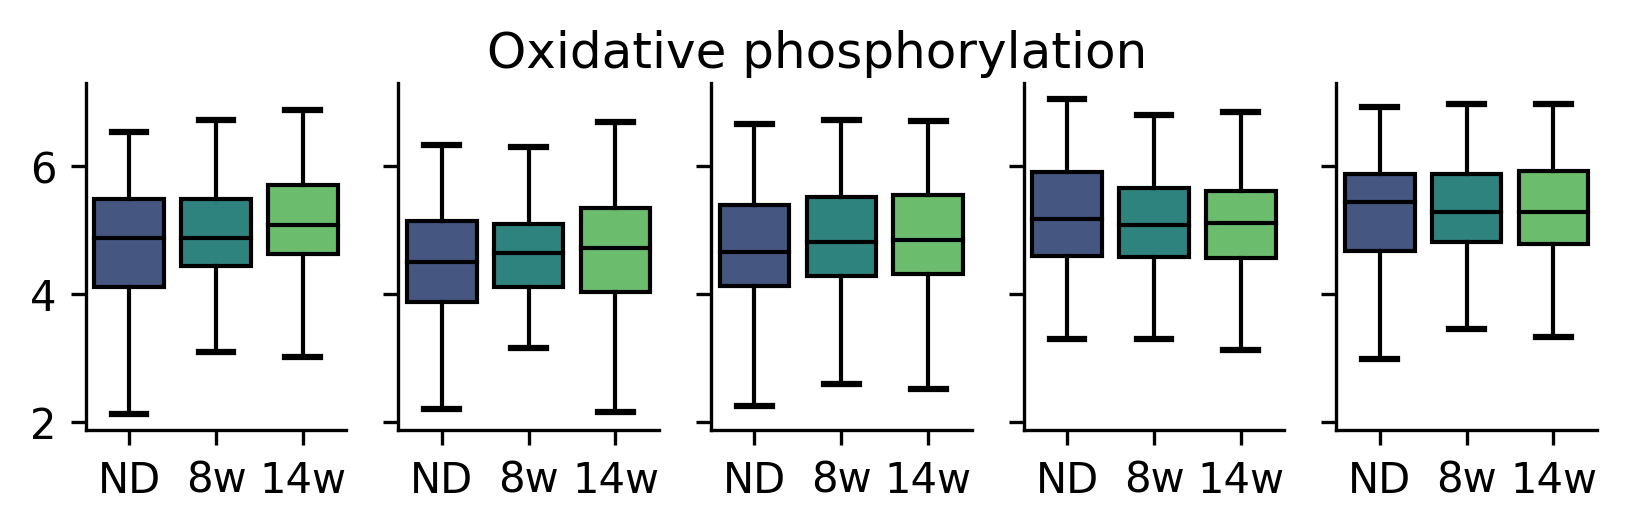

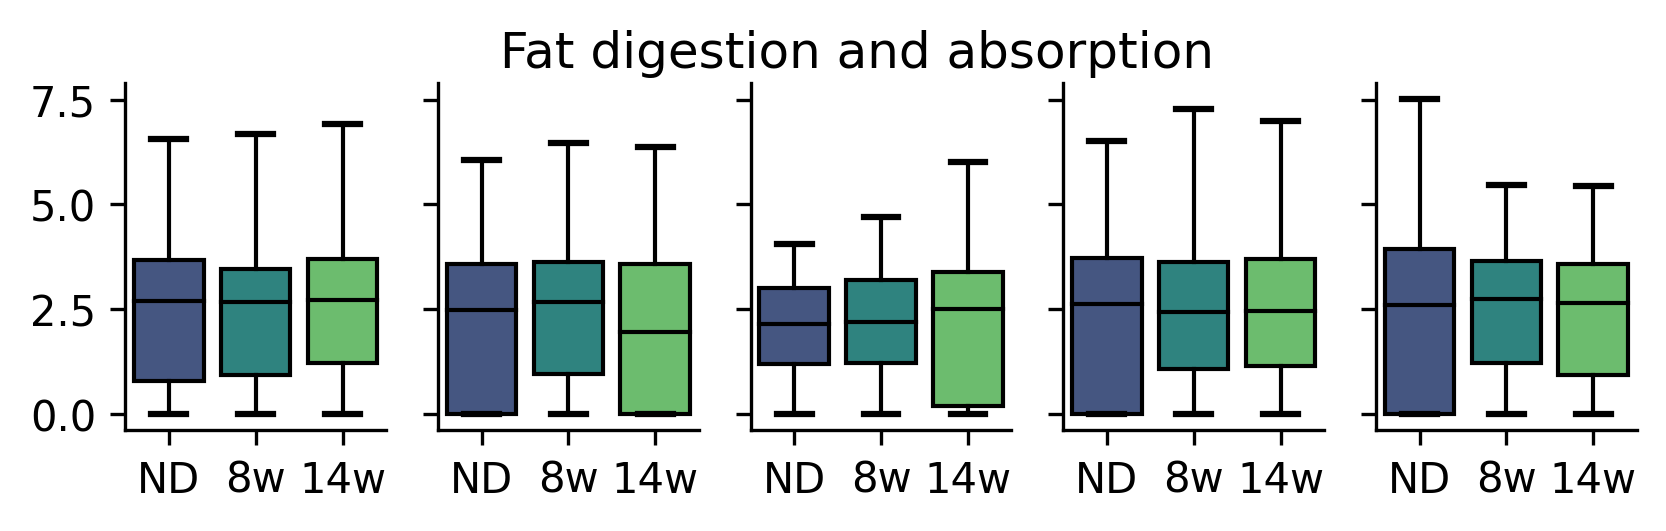

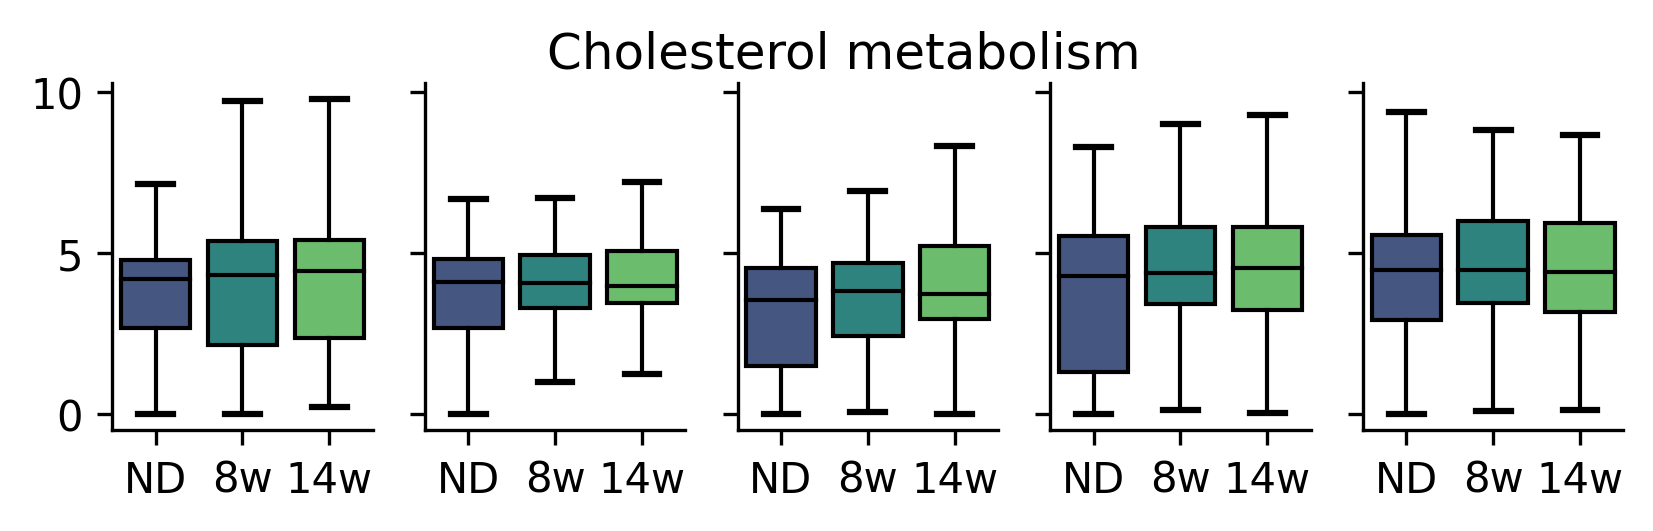

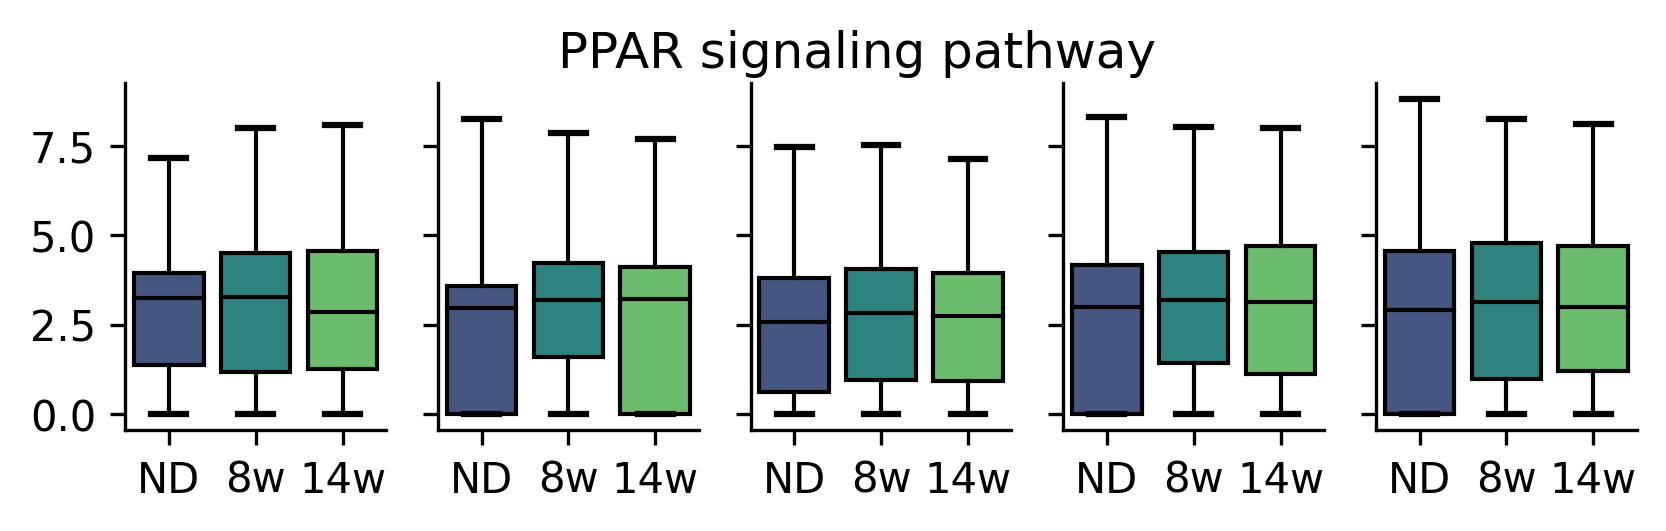

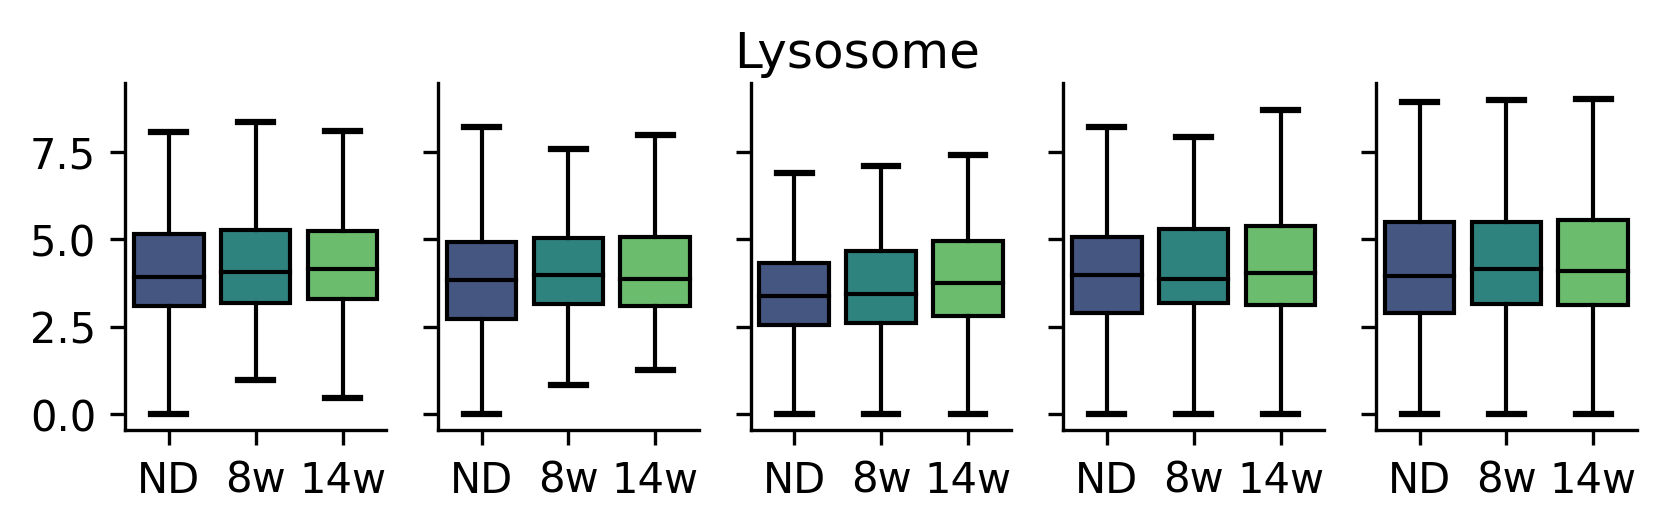

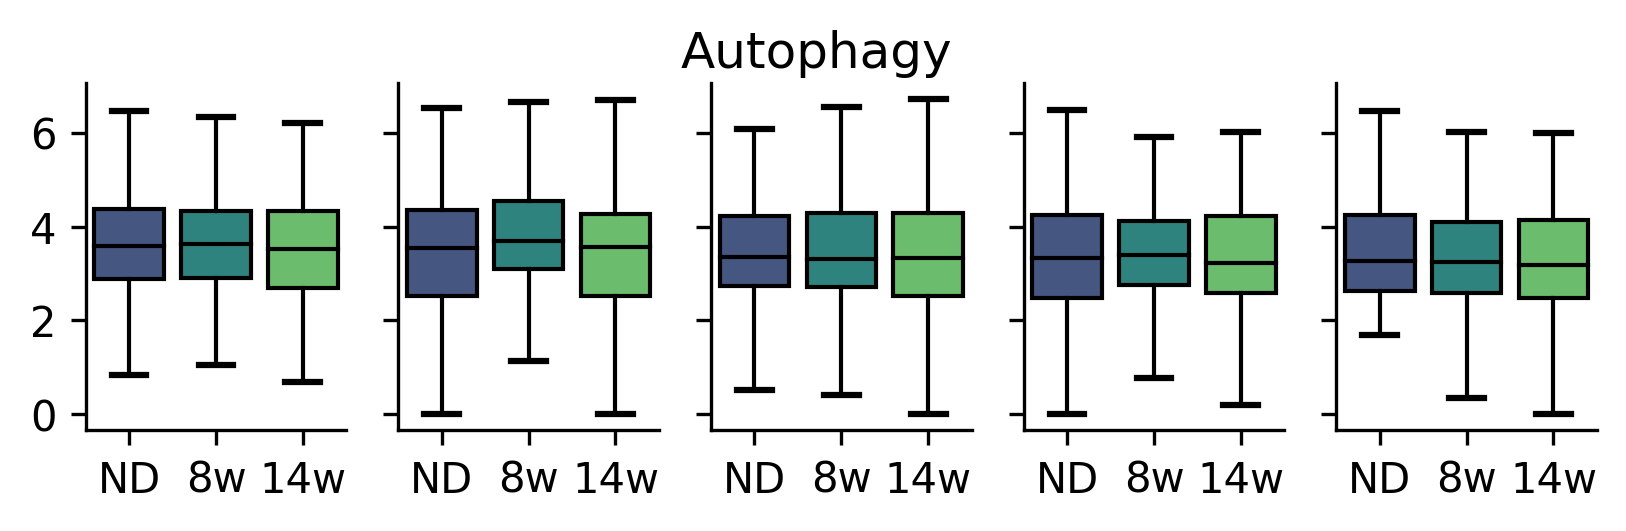

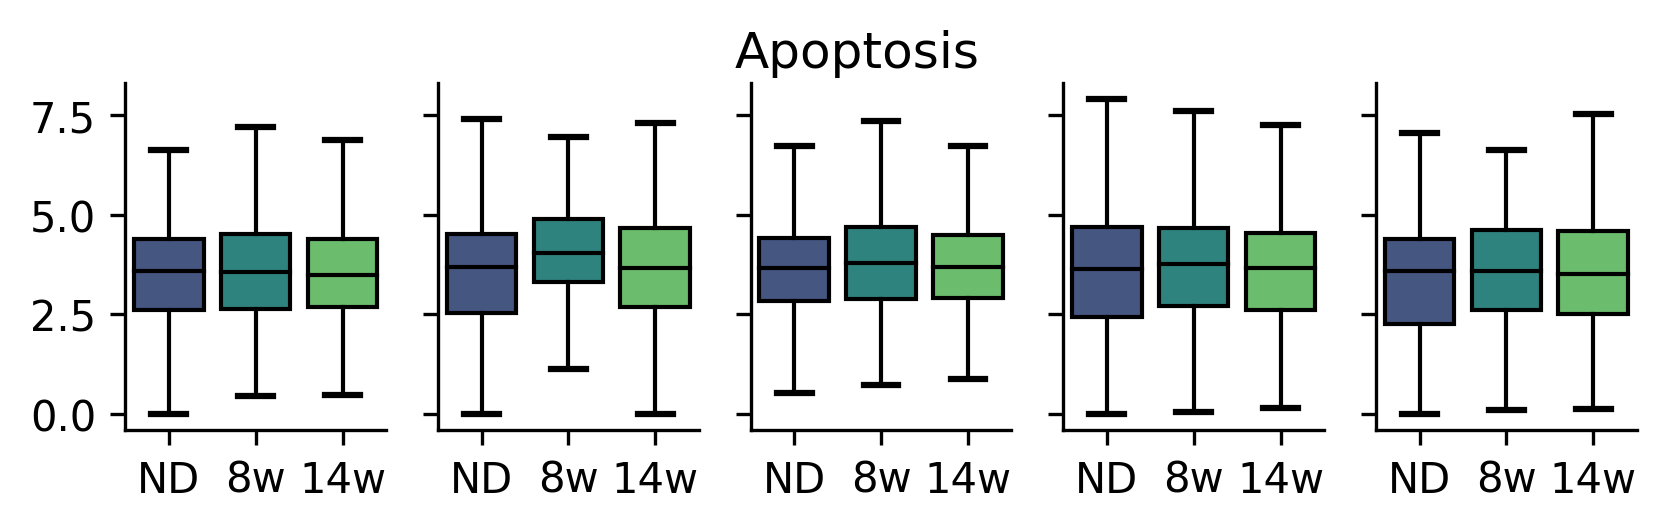

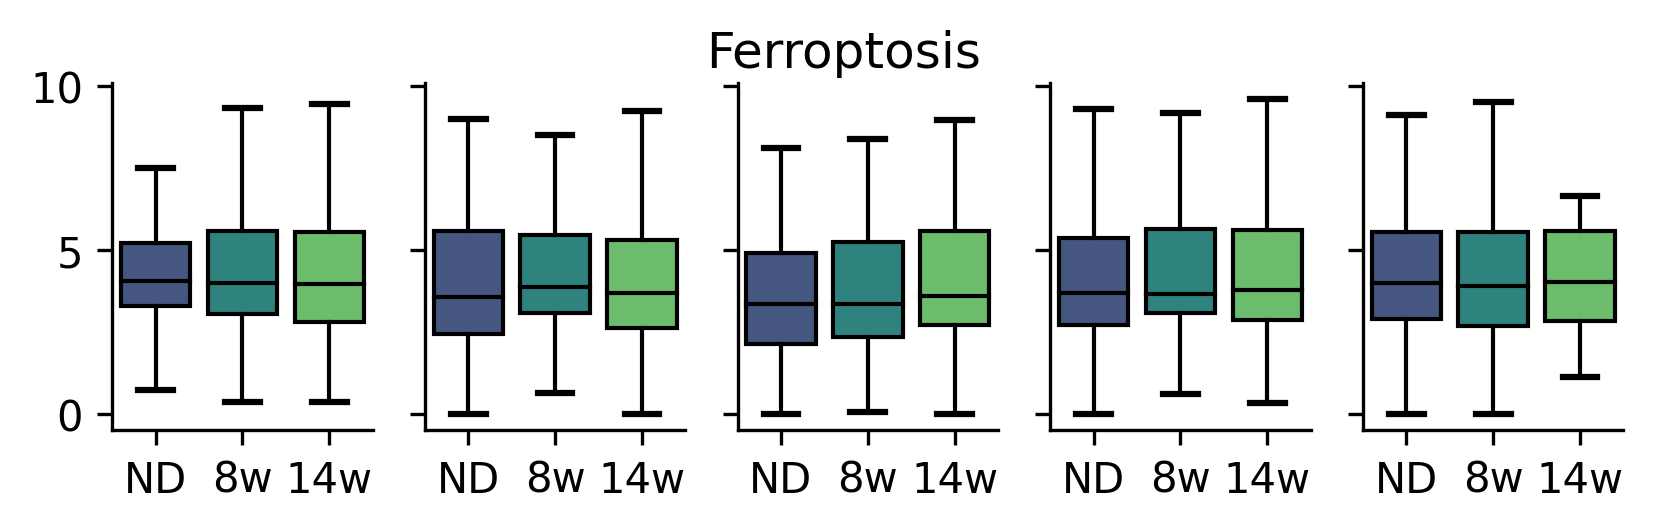

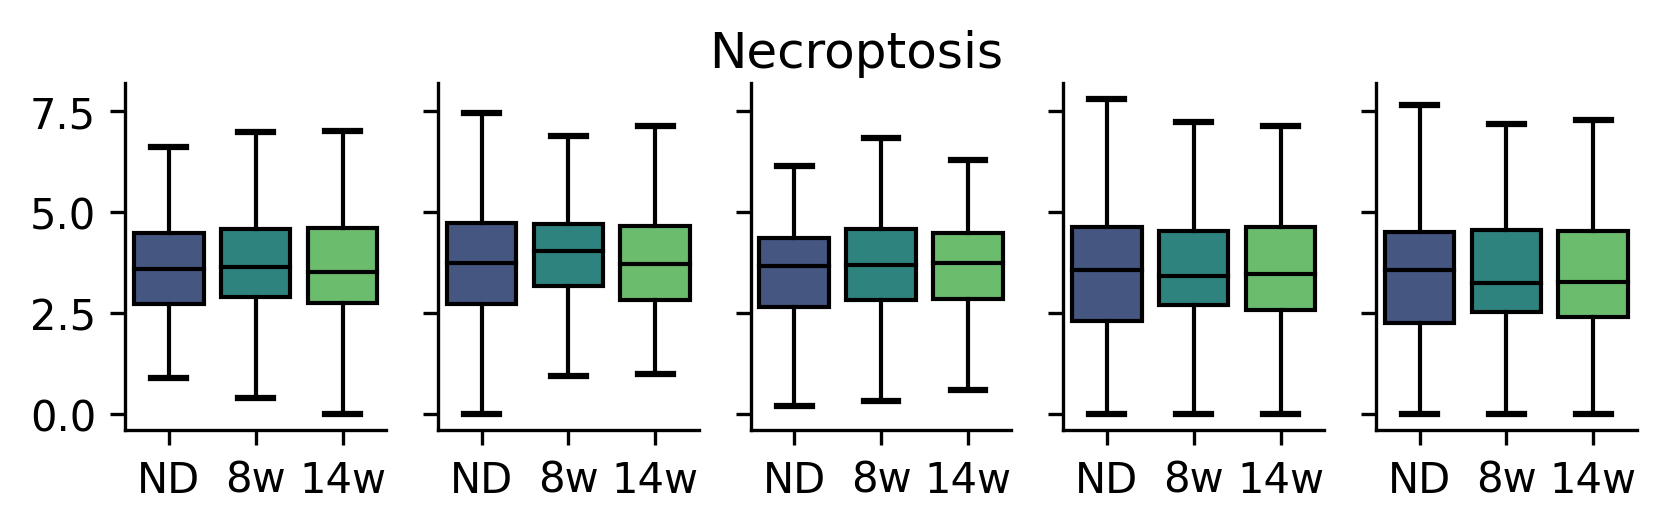

In [90]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6.5, 1.5

keyMap = {
    'ND' : 'ND',
    'HFD8' : '8w',
    'HFD14' : '14w',
}

PROPS = {
    'boxprops':{'edgecolor':'k','linewidth':1},
    'medianprops':{'color':'k', 'linewidth':1},
    'whiskerprops':{'color':'k', 'linewidth':1},
    'capprops':{'color':'k',},
    'flierprops' : {'markerfacecolor':'k', 'markeredgecolor' : 'k', 'markersize' : 2},
}

for pname in pdf['pathway'].unique():    
   
    pGenes = pdf[pdf['pathway'] == pname]['gene'].unique()
    pdx = res[res['gene'].isin(pGenes)]

    # filter out genes whose maximum expression is zero 
    g = pdx.groupby('gene')['meanExp'].max()
    g = g[g > 1].index
    pdx = pdx[pdx['gene'].isin(g)]

    pdx['keyName'] = pdx['key'].map(keyMap)
    

    fig, axs = plt.subplots(1, 5, sharey=True)
    axs = axs.ravel()

    for i, ct in enumerate(macTypes):
        tdf = pdx[pdx['cellType'] == ct].reset_index()

        tdf['meanExp'] = tdf['meanExp'].fillna(0)
        tdf['meanExp'] = np.log1p(tdf['meanExp'])

        sns.boxplot(data=tdf, 
                    x='keyName',
                    y='meanExp',
                    # hue='key',
                    showfliers=False,
                    palette='viridis',
                    ax=axs[i],
                    **PROPS)


        # axs[i].legend().remove()
        axs[i].set_xlabel('')
        axs[i].set_ylabel('')
        # axs[i].set_yscale('log')
        # axs[i].set_xlabel(ct)
            
    
      
    #     axs[i].set_xlabel("")
    #     axs[i].set_title(keyMap[key])
    #     axs[i].tick_params(axis='y', which='major', labelsize=8)

    sns.despine()
    plt.suptitle(pname, y=1)
    plt.show()

    # break

In [ ]:
break

In [ ]:
tdf.head()

In [ ]:
g = pdx.groupby('gene')['meanExp'].max()
g = g[g >0]
g

In [ ]:
g = pdx.groupby()

In [ ]:
res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"{key}...")
    
    for pid, pname in pathways.items():
        genes = pwayGenes[pname]
        exG = [x for x in genes if x in rf.columns]
        
        meanExp = rf[exG].mean(axis=1).reset_index(drop=False)
        meanExp.columns = ['cellId', 'mean']
        meanExp['pway'] = pname
        meanExp['key'] = key
        
        meanExp = pd.merge(meanExp, lf[['cellId', 'cellType', 'x', 'y', 'metaTypes']], 
                       how='left', 
                       right_on='cellId',
                       left_on='cellId')
        
        res.append(meanExp)
    
res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
pdf = res.copy()
pdf = pdf.fillna(0)
print(f"{pdf.shape=}")
pdf = pdf[pdf['mean'] > 0]
print(f"{pdf.shape=}")



g = sns.FacetGrid(pdf, 
                  row="pway", 
                  hue="key", 
                  # sharex=False,
                  height=1, 
                  aspect=5,
                  palette='viridis')

plt.rcParams['figure.facecolor'] = "None"

# Draw the densities in a few steps
g.map(sns.kdeplot, "mean",
      bw_adjust=.5, 
      clip_on=True,
      common_norm=False,
      fill=True, 
      log_scale=True,
      # alpha=0.8, 
      linewidth=1.)

# g.map(sns.kdeplot, "mean", 
#       clip_on=True, 
#       common_norm=False,
#       color="k", 
#       log_scale=True,
#       lw=1, 
#       bw_adjust=.5)

g.set_titles("")

g.set(ylabel="")

g.despine(bottom=False, left=True, right=False)

for ax, label in zip(g.axes.flat, pdf['pway'].unique()):
    ax.text(0, 1, label, 
            fontsize=12,
            ha="left", 
            va="center", 
            transform=ax.transAxes)
    
    ax.set_facecolor('None')


plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
plt.xlabel('Mean Expression')

# sns.move_legend(plt.gca(), 
#                 title="",
#                 frameon=False,
#                 loc='upper right', b
#                 box_to_anchor=(1.4, 1.02))

In [ ]:
break

In [ ]:
?fig.supylabel

In [ ]:
break

In [ ]:
# # try with fold changes

# lfdf = []

# macTypes = [
#     'Mac1',
#     'Mac2',
#     'Mac3',
#     'Mac4',
#     'Mac5',
# ]

# for key in keys:
#     rf = rna[key]
#     lf = labels[key]
#     lf = lf.drop_duplicates(subset='cellId')
    
    
    
# #     cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
# #     rf = rf[rf.index.isin(cellIds)]
# #     print(f"{key}...")
    
#     for mtype in macTypes:
        
#         cellIds = lf[lf['cellType'] == mtype]['cellId'].to_list()
        
#         mask = rf.index.isin(cellIds)
#         inGroup = rf[mask]
#         outGroup = rf[~mask]
        
#         for g in rf.columns:
            
#             score, pval = scipy.stats.ranksums(inGroup[g], 
#                                            outGroup[g],
#                                            alternative='two-sided')

#             lfc = np.log2(inGroup[g].mean()+1) - np.log2(outGroup[g].mean()+1)
            
#             row = {
#                 'key' : key,
#                 'mtype' : mtype,
#                 'gene' : g,
#                 'score' : score,
#                 'pval' : pval,
#                 'log2foldchange' : lfc, 
#                 'inGroup' : inGroup[g].mean(),
#                 'outGroup' : outGroup[g].mean(),
#             }
#             lfdf.append(row)
            

        
        
        
        
        
#     break
    
    
# lfdf = pd.DataFrame(lfdf)
# lfdf.head(10)



In [ ]:
res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

pwayGenes = {
    'Proliferation' : ['MKI67']
}

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"\n{key}...")
    
    for pname, genes in pwayGenes.items():
        xGenes = [x for x in genes if x in rf.columns]
        
        pdf = rf[xGenes].reset_index(drop=False)
        print(pdf.head())
        
        # print(pname)
        break
        
    break
        
#         print(f"{pname} {len(xGenes)}")
        
#         meanExp = rf[xGenes].astype(bool).sum(axis=1).reset_index(drop=False)
#         meanExp.columns = ['cellId', 'mean']
#         meanExp['meanNorm'] = meanExp['mean'] / len(xGenes)
#         meanExp['pway'] = pname
#         meanExp['key'] = key
        
#         meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
#                        how='left', 
#                        right_on='cellId',
#                        left_on='cellId')
        
#         res.append(meanExp)

    
# res = pd.concat(res)
# print(f"{res.shape=}")
# res.head()

In [ ]:
t = rf[xGenes].astype(float)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"

sns.heatmap(data=t.T)

In [ ]:
# t = 0.1 # require t percent of the cells to express this gene

# res = []

# macTypes = [
#     'Mac1',
#     'Mac2',
#     'Mac3',
#     'Mac4',
#     'Mac5',
# ]

# for key in keys:
#     rf = rna[key]
#     lf = labels[key]
#     lf = lf.drop_duplicates(subset='cellId')
    
#     cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
#     rf = rf[rf.index.isin(cellIds)]
#     print(f"\n{key}...")
    
#     n = len(rf)
#     thresh = int(n * t)
#     rfBool = rf.astype(bool).astype(int)
    
#     for pid, pname in pathways.items():
#         genes = pwayGenes[pname]
#         xGenes = [x for x in genes if x in rf.columns]
        
#         geneCounts = rfBool[xGenes].sum(axis=0)
#         cols = geneCounts[geneCounts > thresh].index.to_list()
#         print(f"{pname=} {len(cols)=}")

#         # meanExp = rf[cols].mean(axis=1).reset_index(drop=False)
#         meanExp = rf[cols].max(axis=1).reset_index(drop=False)
#         meanExp.columns = ['cellId', 'mean']
#         meanExp['pway'] = pname
#         meanExp['key'] = key
        
#         meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
#                        how='left', 
#                        right_on='cellId',
#                        left_on='cellId')
        
#         res.append(meanExp)

    
# res = pd.concat(res)
# print(f"{res.shape=}")
# res.head()

In [ ]:

res = []

macTypes = [
    'Mac1',
    'Mac2',
    'Mac3',
    'Mac4',
    'Mac5',
]

for key in keys:
    rf = rna[key]
    lf = labels[key]
    lf = lf.drop_duplicates(subset='cellId')
    
    cellIds = lf[lf['cellType'].isin(macTypes)]['cellId'].to_list()
    rf = rf[rf.index.isin(cellIds)]
    print(f"\n{key}...")
    
    n = len(rf)
    thresh = int(n * t)
    rfBool = rf.astype(bool).astype(int)
    
    for pid, pname in pathways.items():
        genes = pwayGenes[pname]
        xGenes = [x for x in genes if x in rf.columns]
        
        print(f"{pname} {len(xGenes)}")
        
        meanExp = rf[xGenes].astype(bool).sum(axis=1).reset_index(drop=False)
        meanExp.columns = ['cellId', 'mean']
        meanExp['meanNorm'] = meanExp['mean'] / len(xGenes)
        meanExp['pway'] = pname
        meanExp['key'] = key
        
        meanExp = pd.merge(meanExp, lf[['cellId', 'cellType','metaTypes']], 
                       how='left', 
                       right_on='cellId',
                       left_on='cellId')
        
        res.append(meanExp)

    
res = pd.concat(res)
print(f"{res.shape=}")
res.head()

In [ ]:
# pdf = res.copy()
# pdf = pdf.fillna(0)
# print(f"{pdf.shape=}")
# pdf = pdf[pdf['mean'] > 0]
# pdf['index'] = pdf['key'] + "_" + pdf['cellId']
# pdf = pdf.set_index('index')
# print(f"{pdf.shape=}")

# k = pdf[['pway', 'mean']].value_counts().reset_index(drop=False)
# k.columns = ['pway', 'geneCount', 'cellCount']
# k.head()

# sns.barplot(data=k, 
#             y='cellCount',
#              x="geneCount",)

In [ ]:
res.head()

In [ ]:
pdf = res.copy()
pdf = pdf.fillna(0)
print(f"{pdf.shape=}")
pdf = pdf[pdf['mean'] > 0]
pdf['index'] = pdf['key'] + "_" + pdf['cellId']
pdf = pdf.set_index('index')
pdf = pdf.reset_index(drop=False)
print(f"{pdf.shape=}")

# # mask = pdf['cellType'].isin(['Mac1', 'Mac4', 'Mac5'])
# # pdf = pdf[mask]

g = sns.FacetGrid(pdf, 
                  row="pway", 
                  hue="cellType", 
                  height=1, 
                  aspect=6,
                  palette='Spectral')

# Draw the densities in a few steps
g.map(sns.stripplot, 
      "meanNorm", 
      # orient='h',
      # stat='probability',
      # bw_adjust=.5, 
      # clip_on=False,
      # fill=True, 
      # log_scale=True,
      alpha=0.8)


g.set_titles("")

g.set(ylabel="", 
      # ylim=[0, 0.2],
      # yticks=[],
     )
# # g.despine(bottom=False, left=True)

# for ax, label in zip(g.axes.flat, pdf['pway'].unique()):
#     ax.text(0.1, 1, label, 
#             # fontweight="bold", 
#             # color=color,
#             ha="left", 
#             va="center", 
#             transform=ax.transAxes)


# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.02))
# # plt.xlabel('Mean Expression')

In [ ]:
# pdf = res.copy()
# print(f"{pdf.shape=}")
# pdf = pdf[pdf['mean'] > 0]
# print(f"{pdf.shape=}")


# # pdf = pd.pivot_table(pdf, 
# #                      index=['pway', 'cellId'],
# #                      columns='key').reset_index(drop=False)

# # pdf.columns = pdf.columns.droplevel()
# # pdf.columns = ['pway', 'cellId', 'HFD14', 'HFD8', "ND"]
# # pdf = pdf[['pway', 'cellId', "ND", "HFD8", "HFD14"]]
# # pdf = pdf.fillna(0)

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.facecolor'] = "w"


# sns.stripplot(data=pdf,
#               x='mean',
#               y='pway',
#               hue='key',
#               dodge=True,
#               jitter=True,
#               alpha=0.1,
#               zorder=3,
#               palette='viridis',
#               size=2,)
              
# plt.xscale('log')
# plt.grid(True, zorder=1)
# plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.015))



In [ ]:
# sns.swarmplot(data=pdf, 
#               x="mean", 
#               y="pway", 
#               hue="key",
#               dodge=True, 
#               s=2,
#               alpha=.1, 
#               zorder=2,
#               palette='viridis',
# )
# plt.grid(True, zorder=0)

# plt.xscale('log')

# plt.legend(loc='upper right')
# plt.ylabel("")
# plt.xlabel('Mean Expression (CPM)')

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 8, 8
# plt.rcParams['figure.facecolor'] = "w"

# pdf = res.copy()
# pdf['xlog'] = np.log(pdf['x'])
# pdf['ylog'] = np.log(pdf['y'])

# g = sns.catplot(data=pdf,
#                 x="xlog", 
#                 y="ylog", 
#                 hue="key", 
#                 # col="diet",
#                 capsize=.2, 
#                 palette="viridis", 
#                 errorbar="se",
#                 kind="point", 
#                 height=6, 
#                 aspect=.75,
# )

In [ ]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 8, 8
# plt.rcParams['figure.facecolor'] = "w"

# pdf = res.copy()
# pdf['xlog'] = np.log(pdf['x'])
# pdf['ylog'] = np.log(pdf['y'])

# g = sns.swarmplot(data=pdf, 
#                   x="xlog", 
#                   y="ylog", 
#                   hue="key")


In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 8
plt.rcParams['figure.facecolor'] = "w"

pdf = res.copy()
pdf['xlog'] = np.log(pdf['x'])
pdf['ylog'] = np.log(pdf['y'])

h = sns.jointplot(data=pdf,
              dropna=True,
              x='xlog', 
              y='ylog', 
              hue='key',
              kind='kde',
              alpha=0.5,
              ec='k',
              size=10,
              linewidths=0.5,
              palette='viridis')

h.set_axis_labels(xPathname, 
                  yPathname, 
                  fontsize=16)

